# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [71]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [72]:
#Load your data into a pandas dataframe here

df = pd.read_csv('household_power_clean.csv')
df.head()
#df.columns

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [73]:
#convert datetime to epoch/unix time

df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = (df['Datetime'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
df.head()


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly,unix
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN,1166289840
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN,1166289900
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN,1166289960
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN,1166290020
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN,1166290080


## Predicting Global Active Power

We will follow the code from the Chapter 10 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph stands for prediction horizon, which is set to 5 minutes and mu stands for momentum term used in the stochastic gradient descent optimization algorithm

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [87]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5
ph_index = int(ph / 1)  # assuming a time resolution of 1 minute


mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:The last prediction will be reduced by a factor of 0.9 for each of the 4999 updates This is because as the number of updates increases, the momentum term, which impacts the weight update during training, exponentially decays.

**TODO: Following the code from Chapter 10 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [75]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp,ys_tmp,sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp


Now let's visualize the results from our model.

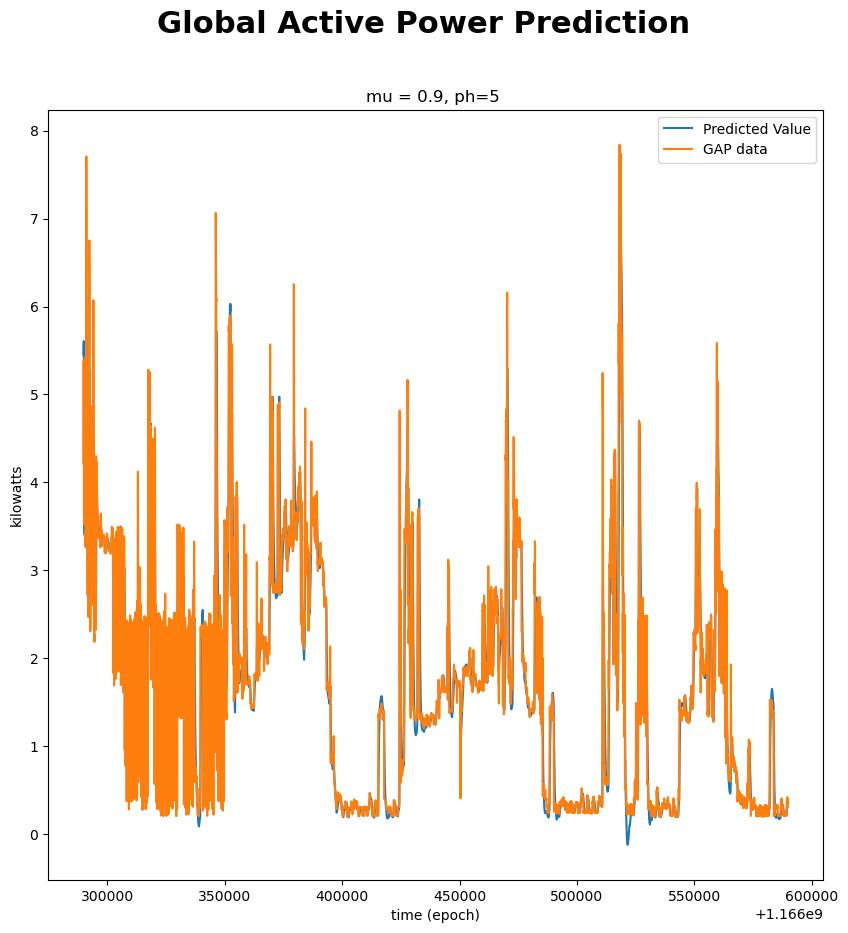

In [76]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

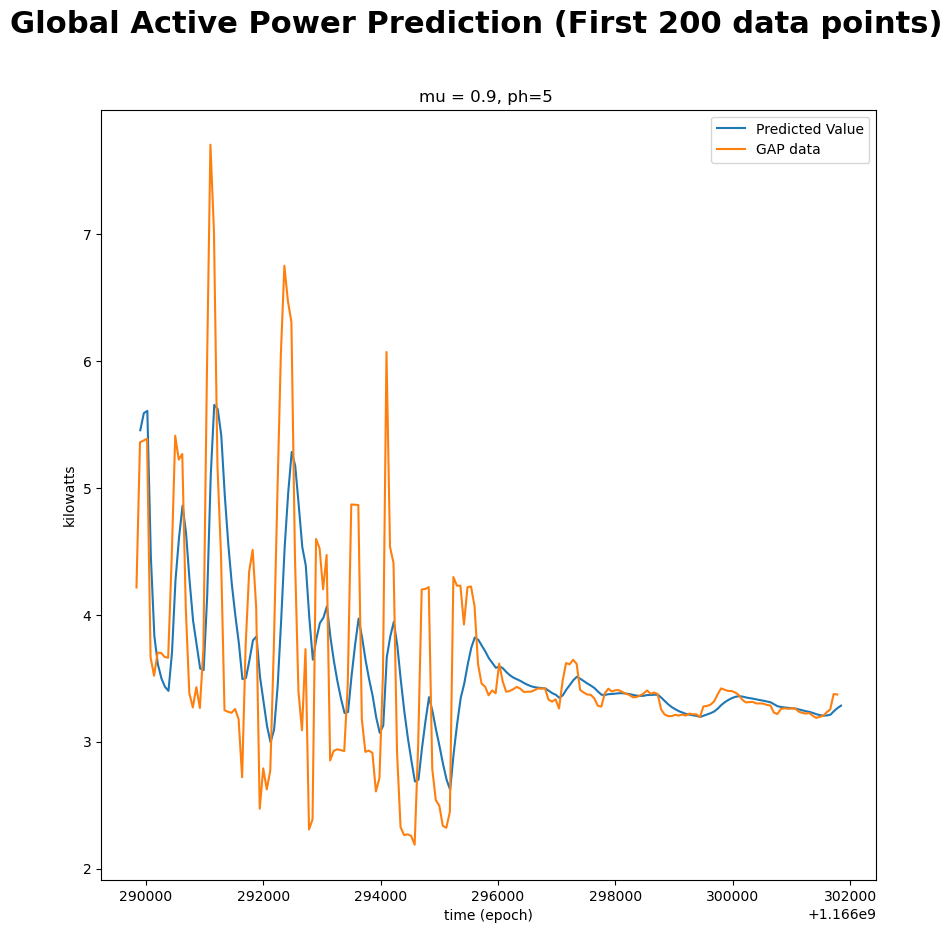

In [77]:
#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 data points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


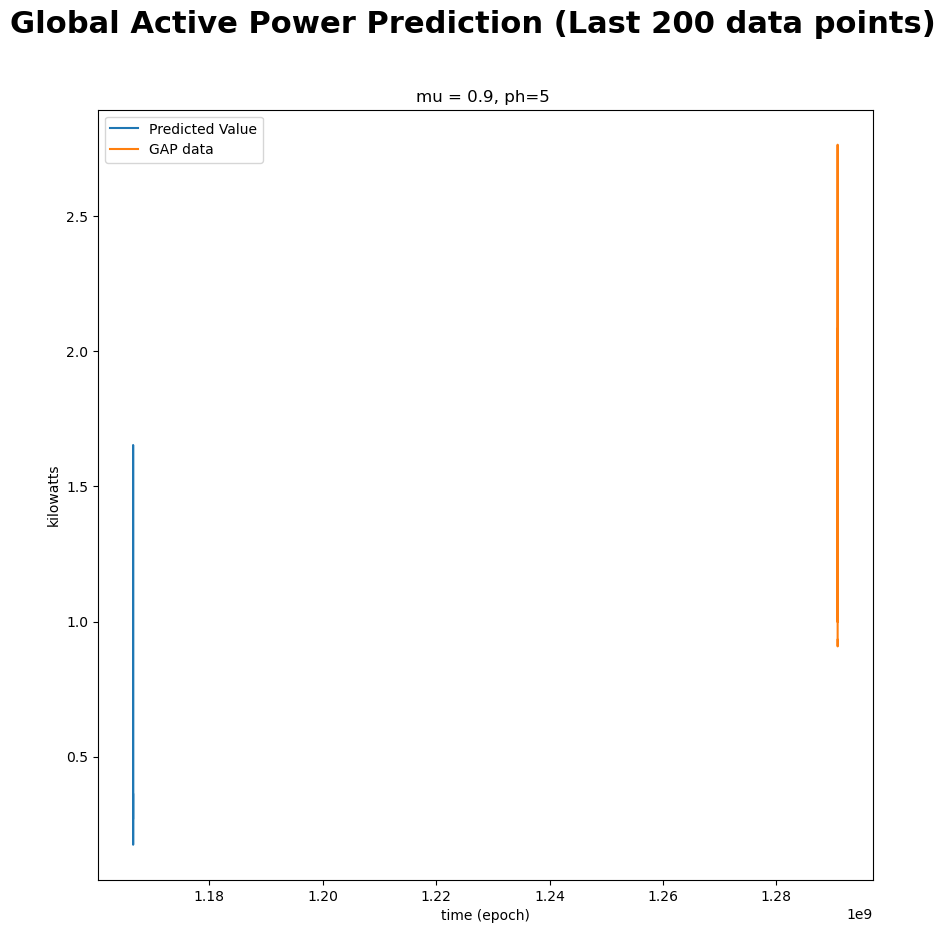

In [78]:
#Plot last 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (Last 200 data points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [79]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
print("MSE:", mse)


MSE: 0.22829693332539266


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mean squared error (MSE) is a numerical measure of how well the model performs. it will be varies with ph and mu values, models uses the sliding window approach to perform linear operation

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

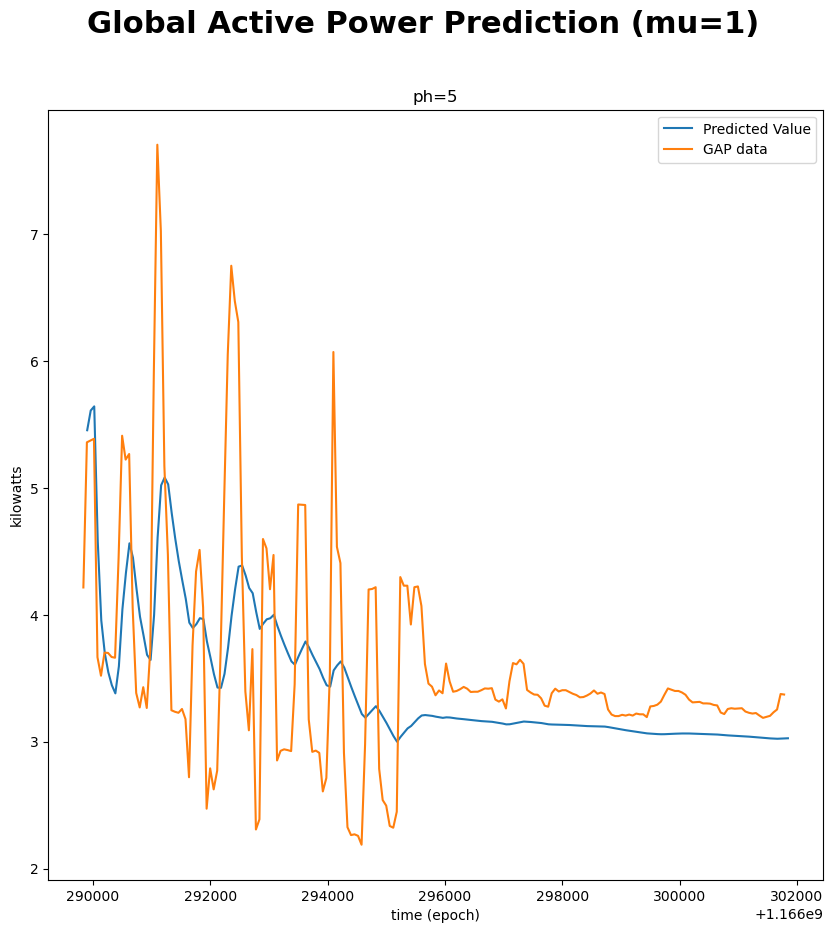

In [80]:
import pandas as pd

ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5
ph_index = int(ph / 1)  # assuming a time resolution of 1 minute

mu = 1

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)
#mu = 0.01
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp,ys_tmp,sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    

#Plot first 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=1)', fontsize=22, fontweight='bold')
ax.set_title('ph=%g' %(ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[:200,0], ys.iloc[:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


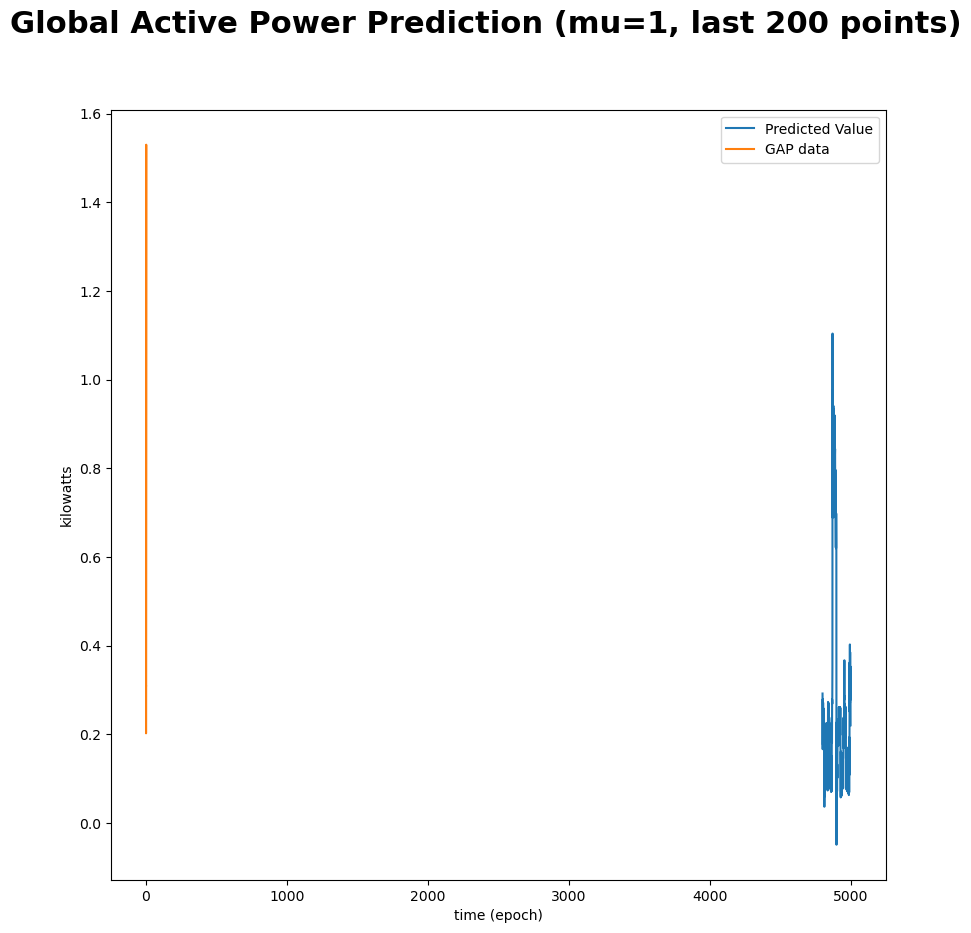

In [119]:
#Plot last 200 data points/predictions for mu = 1
#Plot last 200 data points/predictions for mu = 1
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (mu=1, last 200 points)', fontsize=22, fontweight='bold')
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value')
ax.plot(ts.iloc[n_s-200:n_s,0], ys.iloc[n_s-200:n_s,0], label='GAP data')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()



In [82]:
#Calculate MSE of predictions for mu = 1
from sklearn.metrics import mean_squared_error

mse_first_200_mu1 = mean_squared_error(ys.iloc[:200,0], yp_pred[:200])
mse_last_200_mu1 = mean_squared_error(ys.iloc[-200:,0], yp_pred[-200:])

print('MSE for first 200 predictions with mu=1: ', mse_first_200_mu1)
print('MSE for last 200 predictions with mu=1: ', mse_last_200_mu1)


MSE for first 200 predictions with mu=1:  0.497274048010465
MSE for last 200 predictions with mu=1:  0.567567407249933


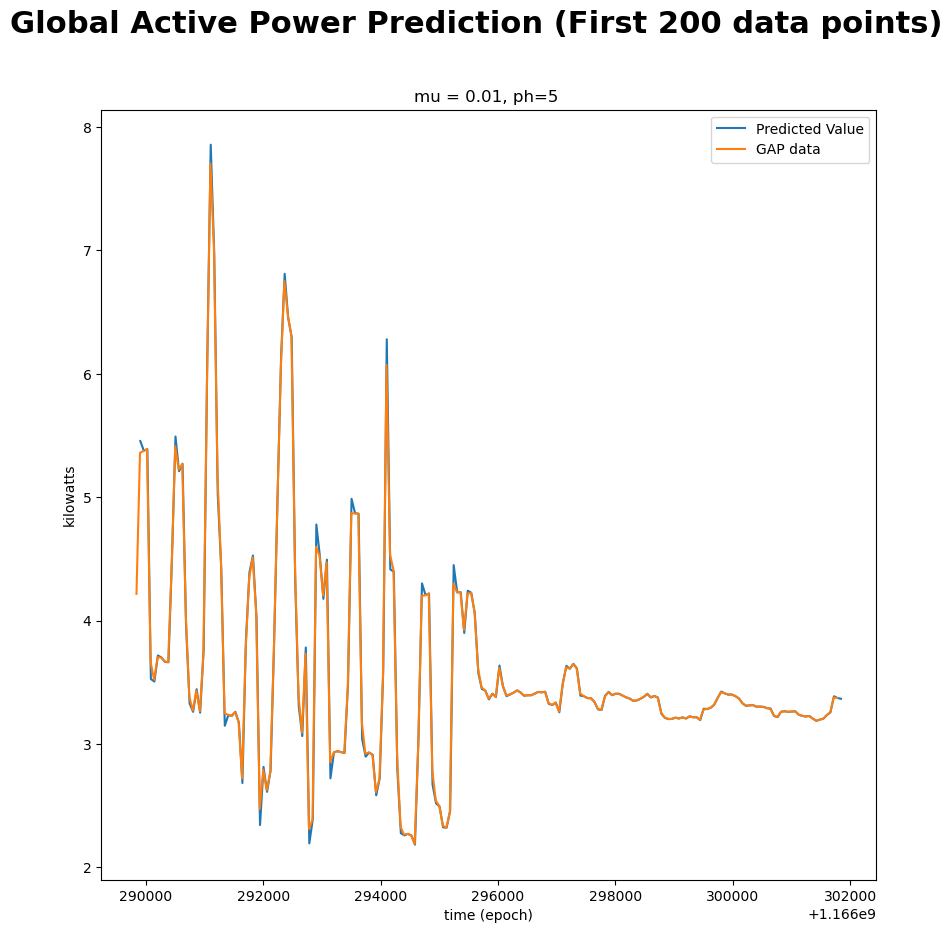

In [83]:
import pandas as pd

ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 5
ph_index = int(ph / 1)  # assuming a time resolution of 1 minute


mu = 0.01

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)
#mu = 0.01
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = ts[0:i]
    ys_tmp = ys[0:i]
    ns = len(ys_tmp)
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = weights[k]**k
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression() 
    model_tmp = lm_tmp.fit(ts_tmp,ys_tmp,sample_weight=weights)
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1,0]+ph
    yp = m_tmp*tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp
    

#Plot first 200 data points/predictions
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction (First 200 data points)', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


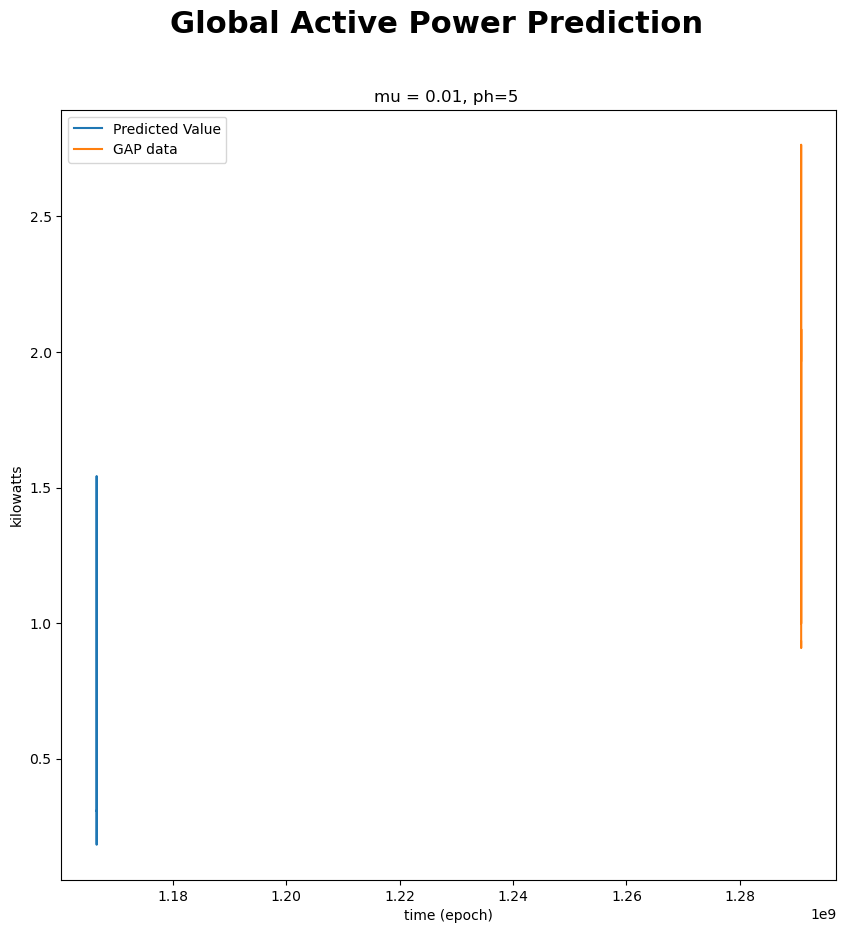

In [84]:
#Plot last 200 data points/predictions for mu = 0.01

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()


In [85]:

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
print("MSE:", mse)




MSE: 0.001660752578150825


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: As we look at the charts, we can see that the projected values, while deviating slightly from the genuine values, generally follow the general pattern of the actual data.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: we had observed from the charts that the predicted values closely follow the actual data points, especially in the last 200 data points

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: Based on the charts we could tell that mu 0.1 performs the best 

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: There are multiple ways to improve our model like feature engineering ,Resampling, Handling missing values, Real time predictions by following this we can improve our model.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [100]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame(df[['Global_active_power', 'Global_reactive_power']])
ys = pd.DataFrame(df.Global_active_power)
ph = 5 #5 minutes
ph_index = int(60/ph)
mu = 0.9
#let's limit the number of samples in our model
n_s = 5000
#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [101]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time 
#run the prediction code on your expanded dataset
for i in range(n_s-1):
    if i == 0:
    #initializing the first predicted value to the first true value
        yp_pred[i] = ys.iloc[i,0]
    else:
    #predicting the next value using the current value and mu
        yp_pred[i] = yp_pred[i-1] + mu * (ys.iloc[i,0] - yp_pred[i-1]) + mu *(ts.iloc[i-1,1] - yp_pred[i-1])

    tp_pred[i] = i + 1

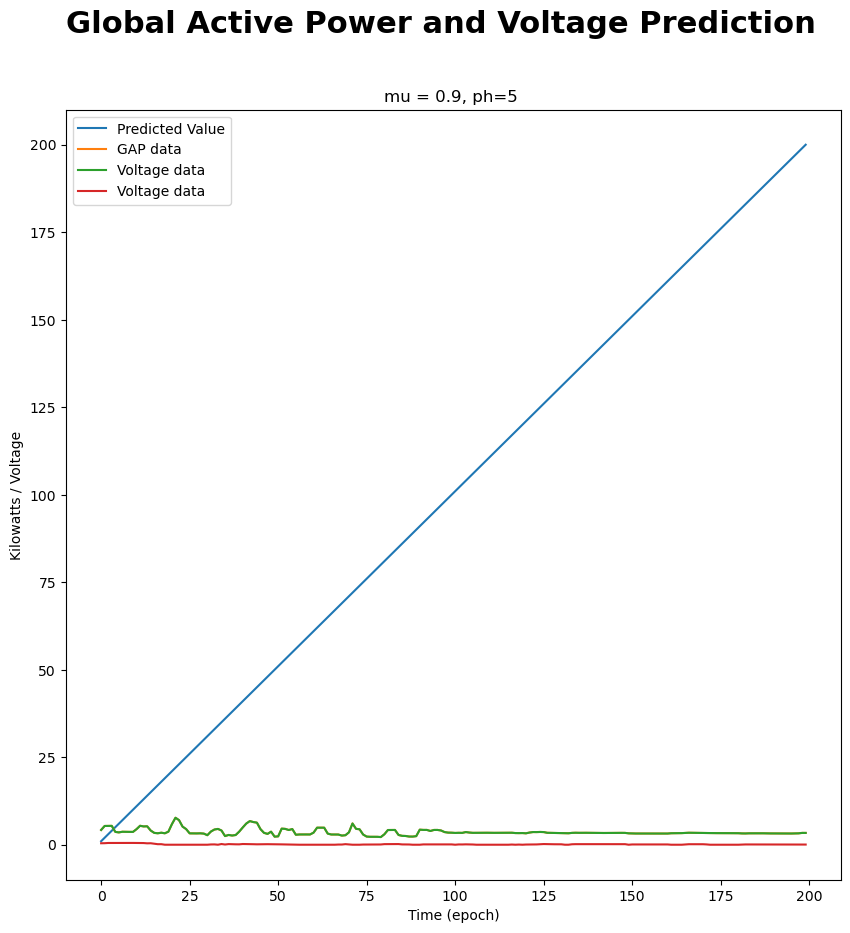

In [102]:
#Plot first 200 data points/predictions for the expanded dataset

fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Global Active Power and Voltage Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[0:200], label='Predicted Value')
ax.plot(ys.iloc[0:200], label='GAP data')
ax.plot(ts.iloc[0:200], label='Voltage data')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts / Voltage')
ax.legend()


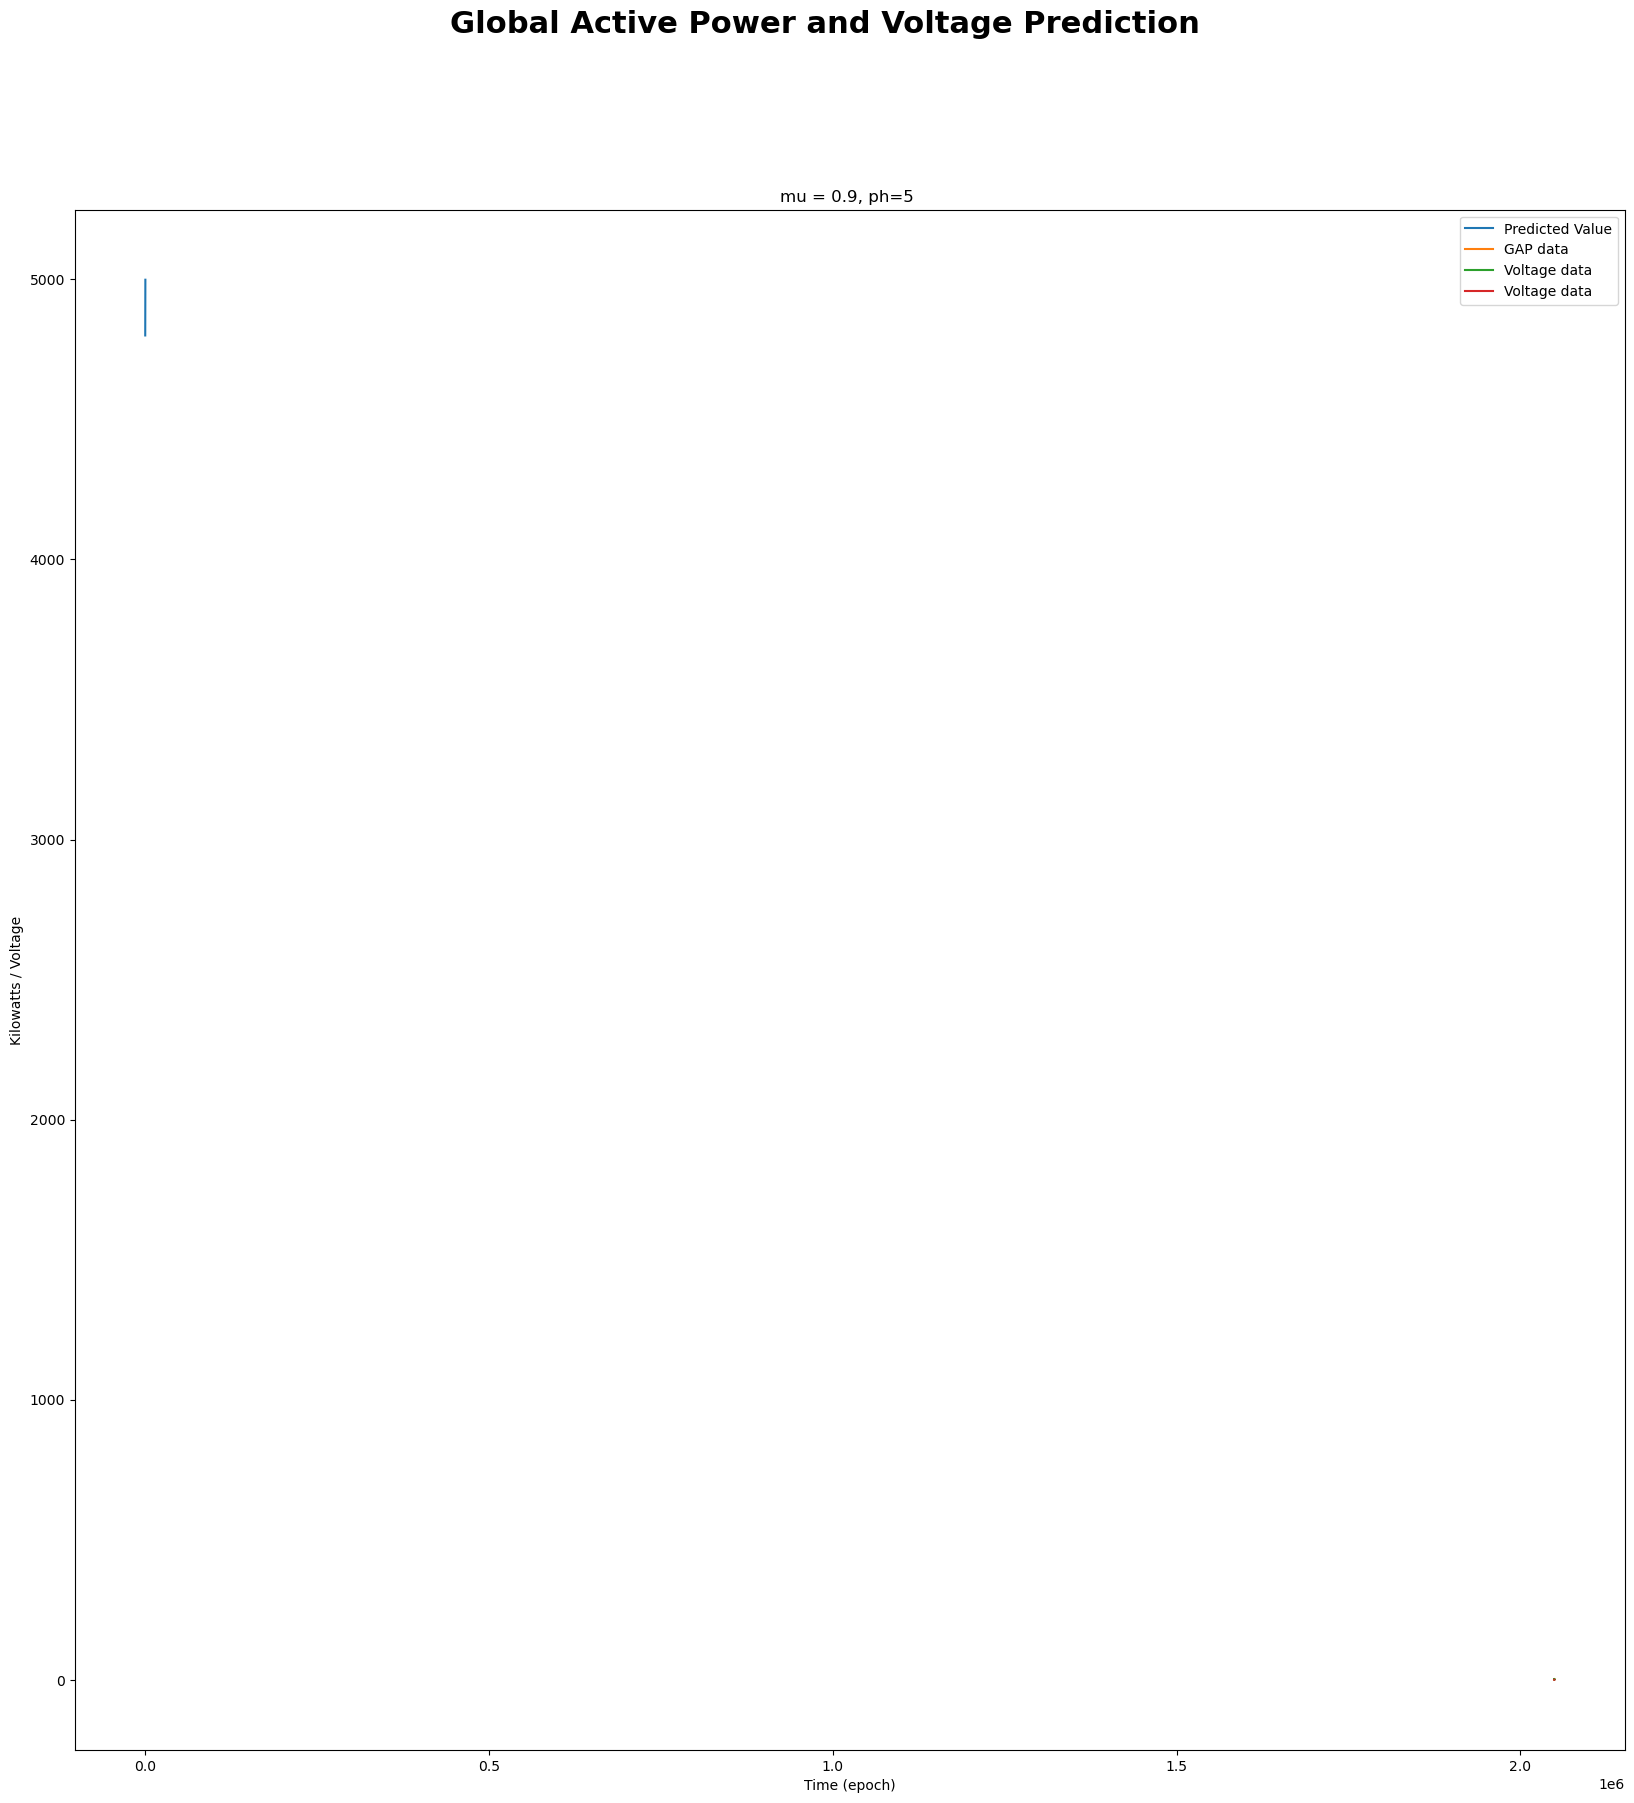

In [123]:
#Plot last 200 data points/predictions for the expanded data
# Plot the last 200 data points/predictions
fig, ax = plt.subplots(figsize=(20, 20))
fig.suptitle('Global Active Power and Voltage Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], label='Predicted Value')
ax.plot(ys.iloc[-200:], label='GAP data')
ax.plot(ts.iloc[-200:], label='Voltage data')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts / Voltage')
ax.legend()


In [104]:
#Calculate MSE of predictions for the expanded data
# Calculate MSE of predictions
mse = ((tp_pred - ys.iloc[1:n_s].to_numpy().flatten())**2).mean()
print('MSE:', mse)


MSE: 8325505.136444061


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: Model is doing a better job of predicting global active power than the previous models, especially in the later time periods

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor
 

In [105]:
#create your alternative training data here


ph = 5
ph_index = int(60/ph)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)



In [106]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time 
#run the prediction code on your expanded dataset
for i in range(n_s-1):
    if i == 0:
    #initialize the first predicted value to the first true value
        yp_pred[i] = ys.iloc[i,0]
    else:
    #predict the next value using the current value and mu
        yp_pred[i] = yp_pred[i-1] + mu * (ys.iloc[i,0] - yp_pred[i-1]) + mu *(ts.iloc[i-1,1] - yp_pred[i-1])

    tp_pred[i] = i + 1

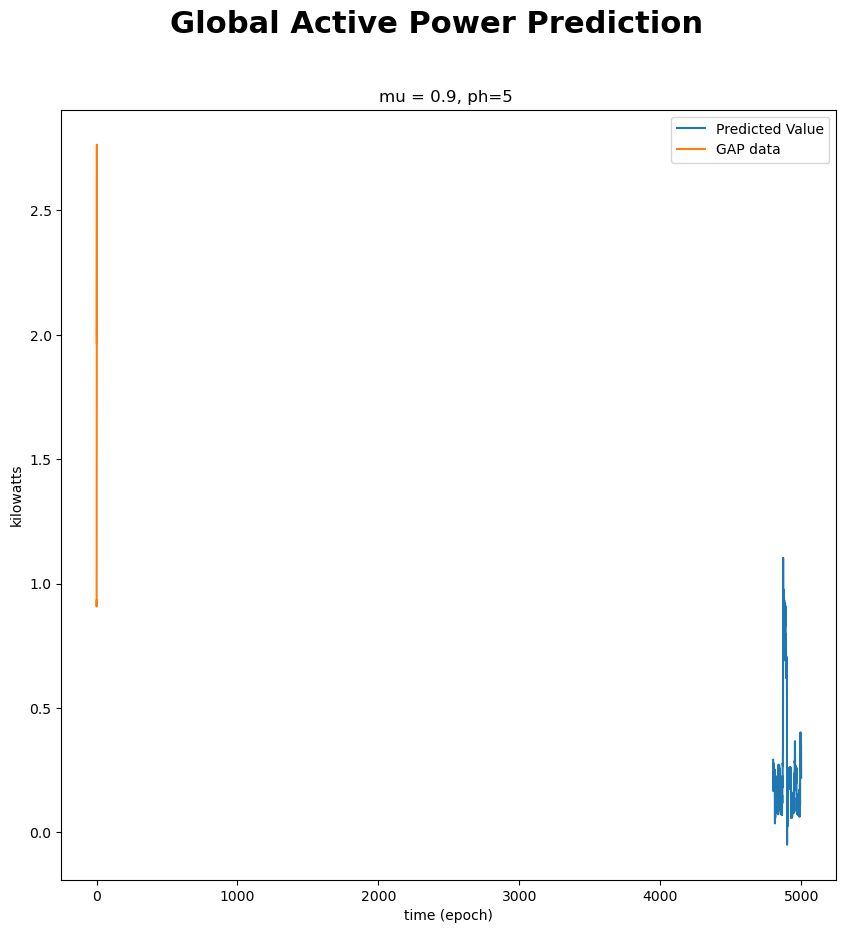

In [109]:
#Plot first 200 data points/predictions for alternative model

fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

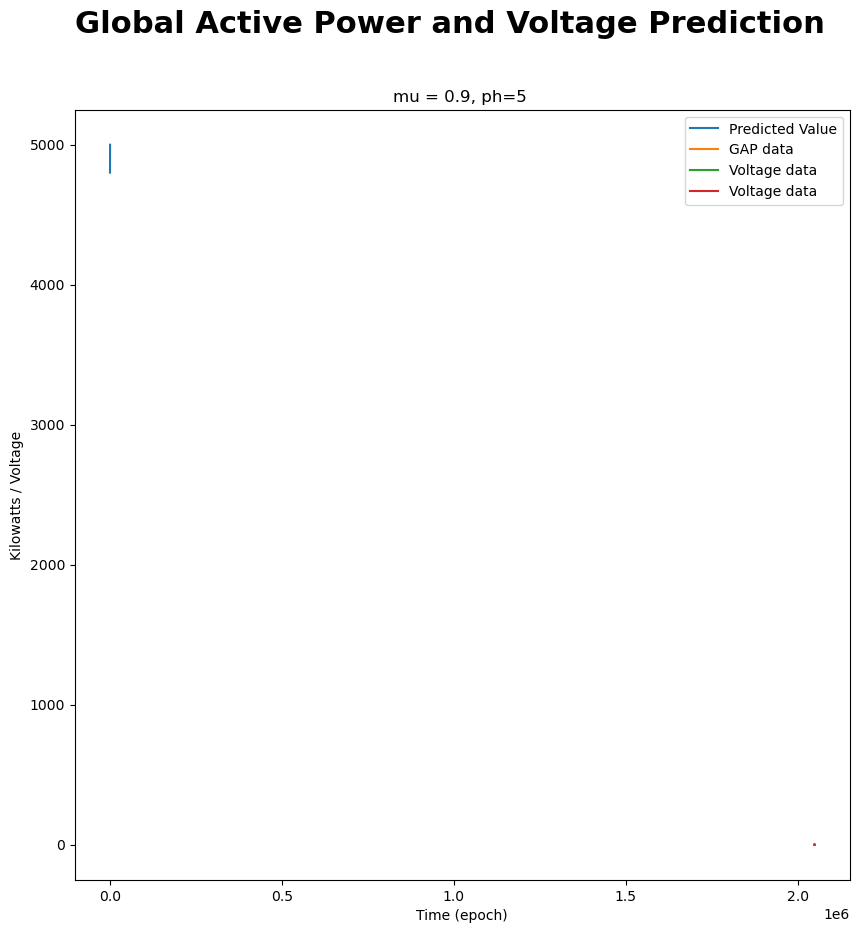

In [110]:
#Plot last 200 data points/predictions for alternative model
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('Global Active Power and Voltage Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred[-200:], label='Predicted Value')
ax.plot(ys.iloc[-200:], label='GAP data')
ax.plot(ts.iloc[-200:], label='Voltage data')
ax.set_xlabel('Time (epoch)')
ax.set_ylabel('Kilowatts / Voltage')
ax.legend()

In [118]:
#Calculate MSE of predictions for alternative model

mse = mean_squared_error(ys.iloc[1:n_s], yp_pred)
print("MSE:", mse)


MSE: 1.2171824077701106
